In [1]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt

# analytic implementation

In [2]:
# U(N) prop id-matrix
def I_U(alpha,N):
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            M[i,j] = special.iv(j-i,2*np.abs(alpha))
    return np.linalg.det(M)

# SU(n) prop id-matrix
def I_SU(alpha,N,max_nu = 100):
    Z = I_U(alpha,N)
    th = np.angle(alpha)
    for nu in range(1,max_nu+1):
        m = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                m[i,j] = special.iv(j-i+nu,2*np.abs(alpha))
        Z += 2 * np.cos(nu*N*th) * np.linalg.det(m)
    return Z

# U(N) arbitary matrix
def Z_U(A,N):
    z = np.sqrt(np.linalg.eig(A.getH()*A)[0].real)
    C = np.prod([np.math.factorial(k) for k in range(N)])
    V = np.vander(z**2)
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            M[i,j] = z[j]**(N-i-1)*special.iv(N-i-1,2*z[j])
    v = np.linalg.det(V)
    m = np.linalg.det(M)
    return m * C / v

# SU(N) arbitary matrix
def Z_SU(A,N,max_nu = 100):
    Z = Z_U(A,N)
    z = np.sqrt(np.linalg.eig(A.getH()*A)[0].real)
    th = np.angle(np.linalg.det(A))
    C = np.prod([np.math.factorial(k) for k in range(N)])
    V = np.vander(z**2)
    v = np.linalg.det(V)
    for nu in range(1,max_nu+1):
        M = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                M[i,j] = z[j]**(N-i-1)*special.iv(N-i-1-nu,2*z[j])
        m = np.linalg.det(M)
        Z += m * C / v * 2 * np.cos(nu*th)
    return Z

# random matrix implementation

In [3]:
# SU(N) and U(N) haar measure by qr decomposition
def qr_special_unitary(n):
    z = np.random.randn(n,n) + 1.0j * np.random.randn(n,n)
    q,r = np.linalg.qr(z)
    d = np.diag(np.diagonal(r) / np.abs(np.diagonal(r)))
    u = np.dot(q, d)
    v = np.conjugate(np.linalg.det(u))**(1 / n)
    return np.matrix(u * v)

def qr_unitary(n):
    z = np.random.randn(n,n) + 1.0j * np.random.randn(n,n)
    q,r = np.linalg.qr(z)
    d = np.diag(np.diagonal(r) / np.abs(np.diagonal(r)))
    u = np.dot(q, d)
    return np.matrix(u)

# SU(2) and U(2) haar measure by creutz
def random_a0():
    a0_new = np.random.rand() * 2 - 1
    if 1-np.sqrt(1-a0_new**2)<np.random.rand():
        return a0_new
    else:
        return random_a0()

s0 = np.array([[1,0],[0,1]])
s1 = np.array([[0,1],[1,0]]) 
s2 = np.array([[0,-1j],[1j,0]]) 
s3 = np.array([[1,0],[0,-1]]) 
    
def creutz_su2():
    a0 = random_a0()
    r = np.sqrt(1-a0**2)
    th = np.random.rand() * 2 * np.pi
    ph = np.random.rand() * np.pi
    a1 = r * np.sin(ph) * np.cos(th)
    a2 = r * np.sin(ph) * np.sin(th)
    a3 = r * np.cos(ph)
    return a0 * s0 + 1j * (a1 * s1 + a2 * s2 + a3 * s3)

def creutz_u2():
    return haar_su2() * np.exp(1j * np.random.rand() * 2 * np.pi)


# SU(N) and U(N) haar measure by cabibbo marinari
def cabibbo_marinari_special_unitary(U,N):
    i = np.random.randint(0,N-1)
    j = np.random.randint(i+1,N)
    m = np.identity(N,dtype=complex)
    mm = creutz_su2()
    m[i,i] = mm[0,0]
    m[i,j] = mm[0,1]
    m[j,i] = mm[1,0]
    m[j,j] = mm[1,1]
    U *= np.matrix(m)
    return U

def cabibbo_marinari_unitary(U,N):
    return cabibbo_marinari_special_unitary(U,N) * np.exp(1j * np.random.rand() * 2 * np.pi)

In [4]:
# arbitary random matrix
def random_matrix(N, prop_id=False, scale=5e-1):
    if prop_id is False:
        return np.matrix(np.random.rand(N,N) + 1.0j * np.random.rand(N,N)) * scale
    else:
        c = (np.random.rand() + 1.0j * np.random.rand()) * scale
        return np.matrix(np.identity(N)) * c
    
# def function
def f(U):
    U = np.matrix(U)
    m = U*A+U.getH()*A.getH()
    return np.exp(np.trace(m))

# numeric integral with cabibbo marinari
def num_cabibbo_marinari_special_unitary(N, n = 500000):
    U = qr_special_unitary(N)
    CM = [f(U).real]
    for k in range(n):
        U = cabibbo_marinari_special_unitary(U,N)
        CM.append(f(U).real)
    return np.average(CM)

def num_cabibbo_marinari_unitary(N, n = 500000):
    U = qr_unitary(N)
    CM = [f(U).real]
    for k in range(n):
        U = cabibbo_marinari_unitary(U,N)
        CM.append(f(U).real)
    return np.average(CM)

# qr vs cabibbo marinari

In [5]:
N = 3
A = random_matrix(N)

In [6]:
qr = np.average([f(qr_special_unitary(N)).real for ii in range(10000)])
cm = num_cabibbo_marinari_special_unitary(N,10000)

print('N = %d\nQR: %f\nCabibbo Marinari: %f'%(N,qr,cm))
print('Ratio: %f'%(qr/cm))

N = 3
QR: 1.699805
Cabibbo Marinari: 1.670446
Ratio: 1.017576


In [7]:
N = 150

%time U = qr_special_unitary(N)
%time U = cabibbo_marinari_special_unitary(U,N)

Wall time: 9.97 ms
Wall time: 997 µs


# numeric vs analytic for $A$ prop id-matrix

In [8]:
N = 2
A = random_matrix(N,prop_id=True)
alpha = A[1,1]

In [9]:
# U(N)
ana1 = I_U(alpha,N)
num1 = num_cabibbo_marinari_unitary(N)
#num1 = np.average([f(qr_unitary(N)).real for ii in range(10000)])

print('N = %d, \u03b1 = %f + %fj\nAnalytic result: I_U = %f\nNumerical result: I_U = %f'%(N,alpha.real,alpha.imag,ana1.real,num1.real))
print('Ratio: %f'%(ana1.real/num1.real))

N = 2, α = 0.247298 + 0.219697j
Analytic result: I_U = 1.115595
Numerical result: I_U = 1.116223
Ratio: 0.999437


In [10]:
# SU(N)
ana2 = I_SU(alpha,N)
num2 = num_cabibbo_marinari_special_unitary(N)
#num2 = np.average([f(qr_special_unitary(N)).real for ii in range(10000)])

print('N = %d, \u03b1 = %f + %fj\nAnalytic result: I_U = %f\nNumerical result: I_U = %f'%(N,alpha.real,alpha.imag,ana2.real,num2.real))
print('Ratio: %f'%(ana2.real/num2.real))

N = 2, α = 0.247298 + 0.219697j
Analytic result: I_U = 1.127402
Numerical result: I_U = 1.125326
Ratio: 1.001844


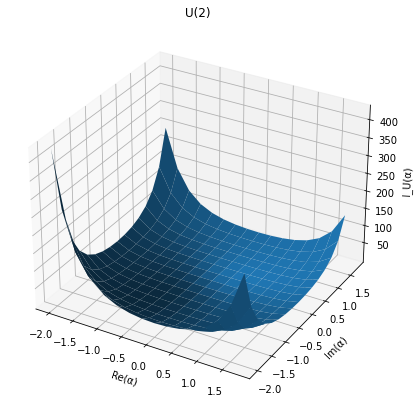

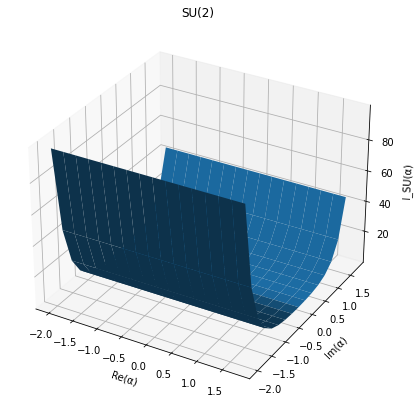

In [11]:
N = 2

fig = plt.figure(figsize=[14,7])
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-2.0, 2.0, 0.25)
X, Y = np.meshgrid(x, y)
n = len(X)
Z = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        Z[i,j] = I_U(x[i] + 1j * y[j],N)

ax.plot_surface(X, Y, Z)

ax.title.set_text('U(%d)'%N)
ax.set_xlabel('Re(\u03b1)')
ax.set_ylabel('Im(\u03b1)')
ax.set_zlabel('I_U(\u03b1)')

plt.show()

fig = plt.figure(figsize=[14,7])
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-2.0, 2.0, 0.25)
X, Y = np.meshgrid(x, y)
n = len(X)
Z = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        Z[i,j] = I_SU(x[i] + 1j * y[j],N)

ax.plot_surface(X, Y, Z)

ax.title.set_text('SU(%d)'%N)
ax.set_xlabel('Re(\u03b1)')
ax.set_ylabel('Im(\u03b1)')
ax.set_zlabel('I_SU(\u03b1)')

plt.show()

# numeric vs analytic for $A$ arbitary

In [12]:
N = 4

A = random_matrix(N) * 2j
i = 0
while(np.abs(Z_U(A,N)-Z_SU(A,N))<1):
    A = random_matrix(N) * 2j
    i += 1

In [13]:
# U(N)
ana3 = Z_U(A,N)
num3 = num_cabibbo_marinari_unitary(N)
#num3 = np.average([f(qr_unitary(N)).real for ii in range(10000)])

print('N = %d\nAnalytic result: Z_U = %f\nNumerical result: Z_U = %f'%(N,ana3.real,num3.real))
print('Ratio: %f'%(ana3.real/num3.real))

N = 4
Analytic result: Z_U = 15.070194
Numerical result: Z_U = 14.917513
Ratio: 1.010235


In [14]:
# SU(N)
ana4 = Z_SU(A,N)
num4 = num_cabibbo_marinari_special_unitary(N)
#num4 = np.average([f(qr_special_unitary(N)).real for ii in range(10000)])

print('N = %d\nAnalytic result: Z_SU = %f\nNumerical result: Z_SU = %f'%(N,ana4.real,num4.real))
print('Ratio: %f'%(ana4.real/num4.real))

N = 4
Analytic result: Z_SU = 14.060123
Numerical result: Z_SU = 14.015574
Ratio: 1.003178
